# Course project
Ник на Kaggle @Natalia_Makarevich

In [1399]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier
import xgboost as xgb

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

import warnings
warnings.filterwarnings("ignore")

## EDA

In [1400]:
data = pd.read_csv('/Users/admin/Desktop/GeekBrains/Рекомендательные_системы/Урок_2_implicit/webinar_2 2/retail_train.csv')
item_features = pd.read_csv('/Users/admin/Desktop/GeekBrains/Рекомендательные_системы/Урок_2_implicit/webinar_2 2/product.csv')
user_features = pd.read_csv('/Users/admin/Desktop/GeekBrains/Рекомендательные_системы/Урок_2_implicit/webinar_2 2/hh_demographic.csv')

In [1401]:
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [1402]:
item_features.head(2)

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [1403]:
user_features.head(2)

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [1404]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2396804 entries, 0 to 2396803
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   user_id            int64  
 1   basket_id          int64  
 2   day                int64  
 3   item_id            int64  
 4   quantity           int64  
 5   sales_value        float64
 6   store_id           int64  
 7   retail_disc        float64
 8   trans_time         int64  
 9   week_no            int64  
 10  coupon_disc        float64
 11  coupon_match_disc  float64
dtypes: float64(4), int64(8)
memory usage: 219.4 MB


In [1405]:
item_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92353 entries, 0 to 92352
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   PRODUCT_ID            92353 non-null  int64 
 1   MANUFACTURER          92353 non-null  int64 
 2   DEPARTMENT            92353 non-null  object
 3   BRAND                 92353 non-null  object
 4   COMMODITY_DESC        92353 non-null  object
 5   SUB_COMMODITY_DESC    92353 non-null  object
 6   CURR_SIZE_OF_PRODUCT  92353 non-null  object
dtypes: int64(2), object(5)
memory usage: 4.9+ MB


In [1406]:
user_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   AGE_DESC             801 non-null    object
 1   MARITAL_STATUS_CODE  801 non-null    object
 2   INCOME_DESC          801 non-null    object
 3   HOMEOWNER_DESC       801 non-null    object
 4   HH_COMP_DESC         801 non-null    object
 5   HOUSEHOLD_SIZE_DESC  801 non-null    object
 6   KID_CATEGORY_DESC    801 non-null    object
 7   household_key        801 non-null    int64 
dtypes: int64(1), object(7)
memory usage: 50.2+ KB


## Зададим число соседей k:

In [1407]:
K_pred = 100 

## Обработка столбцов

In [1408]:
item_features.columns

Index(['PRODUCT_ID', 'MANUFACTURER', 'DEPARTMENT', 'BRAND', 'COMMODITY_DESC',
       'SUB_COMMODITY_DESC', 'CURR_SIZE_OF_PRODUCT'],
      dtype='object')

In [1409]:
user_features.columns

Index(['AGE_DESC', 'MARITAL_STATUS_CODE', 'INCOME_DESC', 'HOMEOWNER_DESC',
       'HH_COMP_DESC', 'HOUSEHOLD_SIZE_DESC', 'KID_CATEGORY_DESC',
       'household_key'],
      dtype='object')

In [1410]:
# обработка названий столбцов
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id' }, inplace=True)

In [1411]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [1412]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [1413]:
data['week_no'].nunique()

95

## Загрузим тестовый датасет (из Kaggle), чтобы его параллельно обрабатывать

In [1414]:
test_user = pd.read_csv('/Users/admin/Desktop/GeekBrains/Рекомендательные_системы/Урок_8_курсовая/test_user.csv')
test_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   UserId  1885 non-null   int64
dtypes: int64(1)
memory usage: 14.9 KB


In [1415]:
test_user.rename(columns={'UserId': 'user_id'}, inplace=True)

In [1416]:
df_test = test_user.merge(data, how='left', on='user_id')

In [1417]:
df_test.user_id.nunique()

1885

In [1418]:
df_test.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,1,2.760128e+10,51.0,825123.0,1.0,3.99,436.0,0.0,1456.0,8.0,0.0,0.0
1,1,2.760128e+10,51.0,831447.0,1.0,2.99,436.0,0.0,1456.0,8.0,0.0,0.0


In [1419]:
df_test['item_id'] = df_test['item_id'].fillna(0)

In [1420]:
df_test['item_id'] = df_test['item_id'].astype('int64')

In [1421]:
df_test.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,1,2.760128e+10,51.0,825123,1.0,3.99,436.0,0.0,1456.0,8.0,0.0,0.0
1,1,2.760128e+10,51.0,831447,1.0,2.99,436.0,0.0,1456.0,8.0,0.0,0.0


## Разделяем датасет на train, eval, test

In [1422]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)


val_lvl_1_size_weeks = 6 # для первого уровня обучения
val_lvl_2_size_weeks = 3 # для второго уровня обучения

In [1423]:
# берем данные для тренировки matching модели (1 уровень)
data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]

# берем данные для валидации matching модели
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

# берем данные для тренировки ranking модели (2 уровень)
data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

In [1424]:
# сделаем объединенный сет данных для первого уровня (матчинга)
df_join_train_lvl_1 = pd.concat([data_train_lvl_1, data_val_lvl_1])

In [1425]:
#функция для выдачи размеров выборки
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data['user_id'].nunique()} Items: {df_data['item_id'].nunique()}")

Посмотрим на размеры получившихся выборок:

In [1426]:
print_stats_data(data_train_lvl_1,'train_lvl_1')
print_stats_data(data_val_lvl_1,'val_lvl_1')
print_stats_data(data_train_lvl_2,'train_lvl_2')
print_stats_data(data_val_lvl_2,'val_lvl_2')

train_lvl_1
Shape: (2108779, 12) Users: 2498 Items: 83685
val_lvl_1
Shape: (169711, 12) Users: 2154 Items: 27649
train_lvl_2
Shape: (169711, 12) Users: 2154 Items: 27649
val_lvl_2
Shape: (118314, 12) Users: 2042 Items: 24329


In [1427]:
data_val_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0


# Prefilter items

In [1428]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features, take_n_popular=3000)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 83685 to 3001


In [1429]:
# ищем общих пользователей
common_users = data_train_lvl_1.user_id.values

data_val_lvl_1 = data_val_lvl_1[data_val_lvl_1.user_id.isin(common_users)]
data_train_lvl_2 = data_train_lvl_2[data_train_lvl_2.user_id.isin(common_users)]
data_val_lvl_2 = data_val_lvl_2[data_val_lvl_2.user_id.isin(common_users)]

print_stats_data(data_train_lvl_1,'train_matcher')
print_stats_data(data_val_lvl_1,'val_matcher')
print_stats_data(data_train_lvl_2,'train_ranker')
print_stats_data(data_val_lvl_2,'val_ranker')

train_matcher
Shape: (606870, 13) Users: 2460 Items: 3001
val_matcher
Shape: (169497, 12) Users: 2144 Items: 27642
train_ranker
Shape: (169497, 12) Users: 2144 Items: 27642
val_ranker
Shape: (117825, 12) Users: 2028 Items: 24296


## Инициализируем наш recommender

В методе fit_own_recommender (обучает модель, которая рекомендует товары, среди товаров, купленных юзером) вместо ItemItemRecommender использовала TFIDFRecommender (показал лучшие результаты по метрикам)

In [1430]:
recommender = MainRecommender(data_train_lvl_1)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/3001 [00:00<?, ?it/s]

## Оценка метрики recall@k на модели 1 уровня

In [1431]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


In [1432]:
%%time

result_lvl_1['candidates_own'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=K_pred))
result_lvl_1['candidates_sim_item'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=K_pred))
result_lvl_1['candidates_als'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=K_pred))

CPU times: user 53.6 s, sys: 6.16 s, total: 59.7 s
Wall time: 17 s


Попробуем оптимизировать гиперпараметры als модели:

In [1434]:
# факторы:

user_item_matrix = recommender.user_item_matrix

for factors in [20, 50, 100]:
    recommender.fit(user_item_matrix, n_factors=factors, regularization=0.001, iterations=15, num_threads=4)
    result_lvl_1[factors] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=K_pred))

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [1435]:
%%time
result_lvl_1['candidates_sim_user'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=K_pred))

CPU times: user 18min 38s, sys: 2min 3s, total: 20min 42s
Wall time: 5min 11s


In [1437]:
# Функция подсчета метрики recall
def recall_calc(data, top_k):
    for col in data.columns[2:]:      
        yield col, data.apply(lambda row: recall_at_k(row[col], row['actual'], k=top_k), axis=1).mean()

In [1438]:
# функция подсчета precision
def precision_calc(data, top_k):
    for col in data.columns[2:]:
        yield col, data.apply(lambda row: precision_at_k(row[col], row['actual'], k=top_k), axis=1).mean()

In [1439]:
top_k_recall= 50

In [1441]:
# коэффициент регуляризации:

for reg in [0.1, 0.01, 0.001]:
    recommender.fit(user_item_matrix, n_factors=factors, regularization=reg, iterations=15, num_threads=4)
    result_lvl_1[reg] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendations(x, N=K_pred))

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

In [1442]:
result_lvl_1.head(2)

,user_id,actual,candidates_own,candidates_sim_item,candidates_als,20,50,100,candidates_sim_user,0.1,0.01,0.001
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[856942, 9297615, 9655212, 5577022, 9527558, 1...","[912704, 1007512, 9296856, 5577022, 923670, 10...","[856942, 8293439, 995598, 9527558, 948832, 108...","[856942, 8293439, 995598, 9527558, 948832, 108...","[856942, 8293439, 995598, 9527558, 948832, 108...","[856942, 8293439, 995598, 9527558, 948832, 108...","[1097909, 5570467, 8293439, 6391213, 904777, 8...","[856942, 8293439, 995598, 9527558, 948832, 108...","[856942, 8293439, 995598, 9527558, 948832, 108...","[856942, 8293439, 995598, 9527558, 948832, 108..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[978332, 911974, 885023, 1076580, 897295, 7410...","[9836106, 8090537, 1007512, 5569845, 880888, 9...","[5569230, 1102067, 1070497, 12731571, 827656, ...","[5569230, 1102067, 1070497, 12731571, 827656, ...","[5569230, 1102067, 1070497, 12731571, 827656, ...","[5569230, 1102067, 1070497, 12731571, 827656, ...","[9677093, 12731571, 944938, 1126890, 1018818, ...","[5569230, 1102067, 1070497, 12731571, 827656, ...","[5569230, 1102067, 1070497, 12731571, 827656, ...","[5569230, 1102067, 1070497, 12731571, 827656, ..."


In [1443]:
sorted(recall_calc(result_lvl_1, top_k_recall), key=lambda x: x[1], reverse=True)

[('candidates_own', 0.0782275147497612),
 ('candidates_als', 0.04747133764099958),
 (20, 0.04747133764099958),
 (50, 0.04747133764099958),
 (100, 0.04747133764099958),
 (0.1, 0.04747133764099958),
 (0.01, 0.04747133764099958),
 (0.001, 0.04747133764099958),
 ('candidates_sim_item', 0.03675461884616637),
 ('candidates_sim_user', 0.01307742611676513)]

Как видим, настройка гиперпараметров модели als все равно проигрывает по сравнению со значением recall у get_own_recommendations

## Наилучший результат по recall дает генерация кандидатов с помощью get_own_recommendations (TFIDFRecommender)

Построим график зависимости recall@k от k для генерации с помощью get_own_recommendations. Возьмем различные k и посмотрим как это влияет на метрику.

In [1444]:
top_k_list = [20, 50, 100, 200, 500]
recall_result = []

In [1445]:
for i in top_k_list:
    recall_result.append(result_lvl_1.apply(lambda row: recall_at_k(row['candidates_own'], row['actual'], k=i), axis=1).mean())

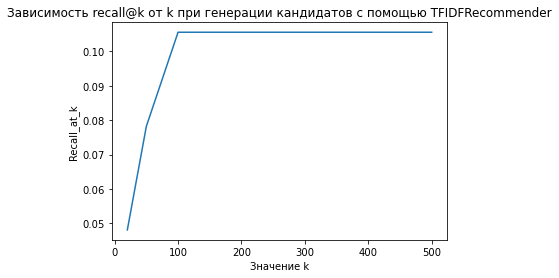

In [1525]:
import matplotlib.pyplot as plt
plt.plot(top_k_list, recall_result)
plt.xlabel('Значение k')
plt.ylabel('Recall_at_k')
plt.title('Зависимость recall@k от k при генерации кандидатов с помощью TFIDFRecommender')
plt.show()

Вывод: значение k=100 в данном случае является оптимальным, так как далее показатель recall уже не растет.

## Precision@5 на модели 1 уровня

In [1449]:
top_k_precision = 5

In [1450]:
sorted(precision_calc(result_lvl_1, top_k_precision), key=lambda x: x[1],reverse=True)

[('candidates_own', 0.21651119402984867),
 ('candidates_als', 0.11389925373134227),
 (20, 0.11389925373134227),
 (50, 0.11389925373134227),
 (100, 0.11389925373134227),
 (0.1, 0.11389925373134227),
 (0.01, 0.11389925373134227),
 (0.001, 0.11389925373134227),
 ('candidates_sim_item', 0.05429104477611984),
 ('candidates_sim_user', 0.026026119402985146)]

Наилучшая метрика также у модели TFIDFRecommender

# Построение модели 2 уровня

### Обучаем модель 2-ого уровня на выбранных кандидатах (товарах)

- Обучаем на data_train_lvl_2
- Обучаем *только* на выбранных товарах
- Сгенерируем топ-50 товаров через get_own_recommendations (были наилучшие показатели по recall@k у модели 1 уровня)
- Если юзер купил < 50 товаров, то get_own_recommendations дополнит рекоммендации топ-популярными

 -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 

## Подготовка данных для трейна

In [1451]:
# взяли пользователей из трейна для ранжирования
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

In [1452]:
# собираем кандитатов с первого этапа (matcher)
users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=K_pred))

In [1453]:
users_lvl_2.head(2)

,user_id,candidates
0,2070,"[944588, 1016800, 1105426, 896292, 1044078, 10..."
1,2021,"[950935, 1119454, 835578, 863762, 1013928, 844..."


In [1454]:
# разворачиваем товары
df_items = users_lvl_2.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = 'item_id'

In [1455]:
users_lvl_2 = users_lvl_2.drop('candidates', axis=1).join(df_items)

In [1456]:
users_lvl_2.head(3)

,user_id,item_id
0,2070,944588
0,2070,1016800
0,2070,1105426


### Проверка warm start

In [1457]:
print_stats_data(users_lvl_2, 'lvl_2_candidates')

lvl_2_candidates
Shape: (214400, 2) Users: 2144 Items: 3000


### Создаем train set для ранжирования с учетом кандидатов с 1 этапа 

In [1458]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только совершенные покупки, обозначены единицей

targets_lvl_2.head()

,user_id,item_id,target
2104867,2070,1019940,1
2107468,2021,840361,1
2107469,2021,856060,1
2107470,2021,869344,1
2107471,2021,896862,1


In [1459]:
targets_lvl_2 = users_lvl_2.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

# чистим дубликаты
targets_lvl_2 = targets_lvl_2.drop_duplicates(subset=['user_id', 'item_id'])

targets_lvl_2['target'].fillna(0, inplace= True)

In [1461]:
targets_lvl_2.target.value_counts(normalize=True)

0.0    0.932486
1.0    0.067514
Name: target, dtype: float64

In [1462]:
targets_lvl_2.head(2)

,user_id,item_id,target
0,2070,944588,0.0
1,2070,1016800,0.0


In [1463]:
targets_lvl_2['target'].mean()

0.06751381688059269

## Подготавливаем фичи для обучения модели

### Описательные фичи

In [1464]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [1465]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [1466]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')

targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc
0,2070,944588,0.0,1094,MEAT-PCKGD,National,LUNCHMEAT,HAM,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown
1,2070,1016800,0.0,103,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown


### Подготовим датасет с фичами и для тестовой выборки:

In [1467]:
df_test = df_test.merge(item_features, on='item_id', how='left')
df_test = df_test.merge(user_features, on='user_id', how='left')

In [1468]:
df_test.user_id.nunique()

1885

### Поведенческие фичи

##### Чтобы считать поведенческие фичи, нужно учесть все данные что были до data_val_lvl_2

In [1060]:
# так выглядел объединенный сет данных для первого уровня (матчинга) выше:
#df_join_train_lvl_1 = pd.concat([data_train_lvl_1, data_val_lvl_1])

In [1469]:
df_join_train_lvl_1.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [1470]:
# сумма покупок товара
targets_lvl_2 = targets_lvl_2.merge(df_join_train_lvl_1.groupby(by='item_id').agg('sales_value').sum().rename('total_item_sales_value'), how='left',on='item_id')

#средняя цена товара
targets_lvl_2 = targets_lvl_2.merge(df_join_train_lvl_1.groupby(by='item_id').agg('sales_value').mean().rename('mean_item_sales_value'), how='left',on='item_id')

# количество купленного товара
targets_lvl_2 = targets_lvl_2.merge(df_join_train_lvl_1.groupby(by='item_id').agg('quantity').sum().rename('total_quantity_value'), how='left',on='item_id')

#сколько юзеров этот товар покупали:
targets_lvl_2 = targets_lvl_2.merge(df_join_train_lvl_1.groupby(by='item_id').agg('user_id').count().rename('item_frequency'), how='left',on='item_id')

# сколько раз юзер совершал покупку
targets_lvl_2 = targets_lvl_2.merge(df_join_train_lvl_1.groupby(by='user_id').agg('user_id').count().rename('user_frequency'), how='left',on='user_id')

# сколько потратил юзер на покупки
targets_lvl_2 = targets_lvl_2.merge(df_join_train_lvl_1.groupby(by='user_id').agg('sales_value').sum().rename('total_user_sales_value'), how='left',on='user_id')

#сколько товаров в неделю покупали в среднем
targets_lvl_2 = targets_lvl_2.merge(df_join_train_lvl_1.groupby(by='item_id').agg('quantity').sum().rename('item_quantity_per_week')/df_join_train_lvl_1.week_no.nunique(), how='left',on='item_id')

# сколько товаров в неделю покупал конкретный юзер
targets_lvl_2 = targets_lvl_2.merge(df_join_train_lvl_1.groupby(by='user_id').agg('quantity').sum().rename('user_quantity_per_week')/df_join_train_lvl_1.week_no.nunique(), how='left',on='user_id')

# число товара в корзине в среднем за одну покупку
targets_lvl_2 = targets_lvl_2.merge(df_join_train_lvl_1.groupby(by='item_id').agg('quantity').sum().rename('item_quantity_per_basket')/df_join_train_lvl_1.basket_id.nunique(), how='left',on='item_id')

# среднее число всех товаров в корзине юзера за одну покупку
targets_lvl_2 = targets_lvl_2.merge(df_join_train_lvl_1.groupby(by='user_id').agg('quantity').sum().rename('user_quantity_per_basket')/df_join_train_lvl_1.basket_id.nunique(), how='left',on='user_id')

# частота покупки товара
targets_lvl_2 = targets_lvl_2.merge(df_join_train_lvl_1.groupby(by='item_id').agg('user_id').count().rename('item_freq_per_basket')/df_join_train_lvl_1.basket_id.nunique(), how='left',on='item_id')

# частота покупок юзера
targets_lvl_2 = targets_lvl_2.merge(df_join_train_lvl_1.groupby(by='user_id').agg('user_id').count().rename('user_freq_per_basket')/df_join_train_lvl_1.basket_id.nunique(), how='left',on='user_id')


### Добавляем те же фичи и в тестовый датасет

In [1471]:
df_test = df_test.merge(df_test.groupby(by='item_id').agg('sales_value').sum().rename('total_item_sales_value'), how='left',on='item_id')
#средняя цена товара
df_test = df_test.merge(df_test.groupby(by='item_id').agg('sales_value').mean().rename('mean_item_sales_value'), how='left',on='item_id')

# количество купленного товара
df_test = df_test.merge(df_test.groupby(by='item_id').agg('quantity').sum().rename('total_quantity_value'), how='left',on='item_id')

#сколько юзеров этот товар покупали:
df_test = df_test.merge(df_test.groupby(by='item_id').agg('user_id').count().rename('item_frequency'), how='left',on='item_id')

# сколько раз юзер совершал покупку
df_test = df_test.merge(df_test.groupby(by='user_id').agg('user_id').count().rename('user_frequency'), how='left',on='user_id')

# сколько потратил юзер на покупки
df_test = df_test.merge(df_test.groupby(by='user_id').agg('sales_value').sum().rename('total_user_sales_value'), how='left',on='user_id')

#сколько товаров в неделю покупали в среднем
df_test = df_test.merge(df_test.groupby(by='item_id').agg('quantity').sum().rename('item_quantity_per_week')/df_test.week_no.nunique(), how='left',on='item_id')

# сколько товаров в неделю покупал конкретный юзер
df_test = df_test.merge(df_test.groupby(by='user_id').agg('quantity').sum().rename('user_quantity_per_week')/df_test.week_no.nunique(), how='left',on='user_id')

# число товара в корзине в среднем за одну покупку
df_test = df_test.merge(df_test.groupby(by='item_id').agg('quantity').sum().rename('item_quantity_per_basket')/df_test.basket_id.nunique(), how='left',on='item_id')

# среднее число всех товаров в корзине юзера за одну покупку
df_test = df_test.merge(df_test.groupby(by='user_id').agg('quantity').sum().rename('user_quantity_per_basket')/df_test.basket_id.nunique(), how='left',on='user_id')

# частота покупки товара
df_test = df_test.merge(df_test.groupby(by='item_id').agg('user_id').count().rename('item_freq_per_basket')/df_test.basket_id.nunique(), how='left',on='item_id')

# частота покупок юзера
df_test = df_test.merge(df_test.groupby(by='user_id').agg('user_id').count().rename('user_freq_per_basket')/df_test.basket_id.nunique(), how='left',on='user_id')


In [1472]:
# число всех купленных товаров у юзера
targets_lvl_2 = targets_lvl_2.merge(df_join_train_lvl_1.groupby(by=['user_id', 'item_id']).agg('quantity').sum().rename('user_item_total_quantity_value'), how='left',on=['user_id', 'item_id'])

In [1473]:
df_test = df_test.merge(df_test.groupby(by=['user_id', 'item_id']).agg('quantity').sum().rename('user_item_total_quantity_value'), how='left',on=['user_id', 'item_id'])

In [1474]:
#среднее количество покупок товаров у юзера
targets_lvl_2 = targets_lvl_2.merge(df_join_train_lvl_1.groupby(by=['user_id', 'item_id']).agg('quantity').mean().rename('user_item_mean_quantity_value'), how='left',on=['user_id', 'item_id'])

In [1475]:
df_test = df_test.merge(df_join_train_lvl_1.groupby(by=['user_id', 'item_id']).agg('quantity').mean().rename('user_item_mean_quantity_value'), how='left',on=['user_id', 'item_id'])

In [1476]:
# среднее число покупок товара определенной категории в неделю (91 - это число недель в выборке)
targets_lvl_2 = targets_lvl_2.merge(targets_lvl_2.groupby(by=['user_id','department']).agg('item_id').count().rename('item_by_department_per_week')/91,how='left', on=['user_id', 'department'])

In [1477]:
df_test = df_test.merge(targets_lvl_2.groupby(by=['user_id','department']).agg('item_id').count().rename('item_by_department_per_week')/91,how='left', on=['user_id', 'department'])

In [1479]:
# среднее число покупок товара определенной категории в неделю (91 - это число недель в выборке)
targets_lvl_2 = targets_lvl_2.merge(targets_lvl_2.groupby(by=['item_id','department']).agg('item_id').count().rename('user_by_department_per_week')/91,how='left', on=['item_id', 'department'])

In [1478]:
df_test = df_test.merge(targets_lvl_2.groupby(by=['item_id','department']).agg('item_id').count().rename('user_by_department_per_week')/91,how='left', on=['item_id', 'department'])

In [1480]:
# сколько потратил юзер на покупки, товары сгруппированы 
targets_lvl_2 = targets_lvl_2.merge(df_join_train_lvl_1.groupby(by=['user_id', 'item_id']).agg('sales_value').sum().rename('total_user_item_sales_value'), how='left',on=['user_id', 'item_id'])

In [1481]:
df_test = df_test.merge(df_test.groupby(by=['user_id', 'item_id']).agg('sales_value').sum().rename('total_user_item_sales_value'), how='left',on=['user_id', 'item_id'])

In [1483]:
targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,user_quantity_per_week,item_quantity_per_basket,user_quantity_per_basket,item_freq_per_basket,user_freq_per_basket,user_item_total_quantity_value,user_item_mean_quantity_value,item_by_department_per_week,user_by_department_per_week,total_user_item_sales_value
0,2070,944588,0.0,1094,MEAT-PCKGD,National,LUNCHMEAT,HAM,12 OZ,45-54,...,1218.32967,0.000306,0.452137,0.000273,0.00814,4.0,1.0,0.219780,0.868132,14.67
1,2070,1016800,0.0,103,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,...,1218.32967,0.003038,0.452137,0.001835,0.00814,10.0,2.0,0.593407,1.582418,25.76


In [1484]:
df_test.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,...,user_quantity_per_week,item_quantity_per_basket,user_quantity_per_basket,item_freq_per_basket,user_freq_per_basket,user_item_total_quantity_value,user_item_mean_quantity_value,item_by_department_per_week,user_by_department_per_week,total_user_item_sales_value
0,1,2.760128e+10,51.0,825123,1.0,3.99,436.0,0.0,1456.0,8.0,...,19.410526,0.000248,0.008018,0.000235,0.006909,4.0,1.333333,0.758242,NaN,11.98
1,1,2.760128e+10,51.0,831447,1.0,2.99,436.0,0.0,1456.0,8.0,...,19.410526,0.000161,0.008018,0.000139,0.006909,2.0,1.000000,0.758242,NaN,5.98


## Готовим датасет для обучения модели

In [1485]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [1486]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210431 entries, 0 to 210430
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   user_id                         210431 non-null  int64  
 1   item_id                         210431 non-null  int64  
 2   manufacturer                    210431 non-null  int64  
 3   department                      210431 non-null  object 
 4   brand                           210431 non-null  object 
 5   commodity_desc                  210431 non-null  object 
 6   sub_commodity_desc              210431 non-null  object 
 7   curr_size_of_product            210431 non-null  object 
 8   age_desc                        78890 non-null   object 
 9   marital_status_code             78890 non-null   object 
 10  income_desc                     78890 non-null   object 
 11  homeowner_desc                  78890 non-null   object 
 12  hh_comp_desc    

In [1487]:
cat_feats = ['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [1488]:
X_train[cat_feats] = X_train[cat_feats].astype('category')

In [1490]:
test_columns = X_train.columns.to_list()

In [1491]:
df_test = df_test[test_columns]
df_test.head(2)

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,...,user_quantity_per_week,item_quantity_per_basket,user_quantity_per_basket,item_freq_per_basket,user_freq_per_basket,user_item_total_quantity_value,user_item_mean_quantity_value,item_by_department_per_week,user_by_department_per_week,total_user_item_sales_value
0,1,825123,1179.0,GROCERY,National,SALD DRSNG/SNDWCH SPRD,SEMI-SOLID SALAD DRESSING MAY,30 OZ,65+,A,...,19.410526,0.000248,0.008018,0.000235,0.006909,4.0,1.333333,0.758242,NaN,11.98
1,1,831447,317.0,GROCERY,National,CHEESE,SHREDDED CHEESE,8 OZ,65+,A,...,19.410526,0.000161,0.008018,0.000139,0.006909,2.0,1.000000,0.758242,NaN,5.98


In [1492]:
df_test[cat_feats] = df_test[cat_feats].astype('category')

## Обучение модели ранжирования

In [1074]:
# %%time
# lgb = LGBMClassifier(objective='binary',
#                      max_depth=10,
#                      n_estimators=200,
#                      learning_rate=0.1,
#                      categorical_column=cat_feats,
#                      n_jobs=-1)

# lgb.fit(X_train, y_train)

Сделаем подбор оптимальных параметров для модели LGBMClassifier

In [1493]:
from sklearn.model_selection import GridSearchCV

In [1494]:
params = {'max_depth': [4, 7, 10],
          'n_estimators': [100, 200, 500],
          'learning_rate': [0.1, 0.5, 1.0]}

In [1495]:
# clf = LGBMClassifier(categorical_column=cat_feats)

# grid = GridSearchCV(clf, params, cv=5)
# grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LGBMClassifier(categorical_column=['manufacturer',
                                                          'department', 'brand',
                                                          'commodity_desc',
                                                          'sub_commodity_desc',
                                                          'curr_size_of_product',
                                                          'age_desc',
                                                          'marital_status_code',
                                                          'income_desc',
                                                          'homeowner_desc',
                                                          'hh_comp_desc',
                                                          'household_size_desc',
                                                          'kid_category_desc']),
             param_grid={'learning_rate': [0.1, 0.5,

In [1496]:
grid.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}

In [1497]:
%%time
final_lgb = LGBMClassifier(objective='binary',
                     max_depth=4,
                     n_estimators=100,
                     learning_rate=0.1,
                     categorical_column=cat_feats,
                     n_jobs=-1)

final_lgb.fit(X_train, y_train)

CPU times: user 7.28 s, sys: 1 s, total: 8.28 s
Wall time: 1.45 s


LGBMClassifier(categorical_column=['manufacturer', 'department', 'brand',
                                   'commodity_desc', 'sub_commodity_desc',
                                   'curr_size_of_product', 'age_desc',
                                   'marital_status_code', 'income_desc',
                                   'homeowner_desc', 'hh_comp_desc',
                                   'household_size_desc', 'kid_category_desc'],
               max_depth=4, objective='binary')

In [1498]:
train_preds = final_lgb.predict_proba(X_train)

### Создаем датасет с предсказаниями модели:

In [1499]:
df_ranker_predict = targets_lvl_2.copy()

In [1500]:
df_ranker_predict['proba_item_purchase'] = train_preds[:,1]

In [1501]:
df_ranker_predict.head(3)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,...,item_quantity_per_basket,user_quantity_per_basket,item_freq_per_basket,user_freq_per_basket,user_item_total_quantity_value,user_item_mean_quantity_value,item_by_department_per_week,user_by_department_per_week,total_user_item_sales_value,proba_item_purchase
0,2070,944588,0.0,1094,MEAT-PCKGD,National,LUNCHMEAT,HAM,12 OZ,45-54,...,0.000306,0.452137,0.000273,0.00814,4.0,1.0,0.219780,0.868132,14.67,0.200808
1,2070,1016800,0.0,103,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,45-54,...,0.003038,0.452137,0.001835,0.00814,10.0,2.0,0.593407,1.582418,25.76,0.154326
2,2070,1105426,0.0,69,DELI,Private,SANDWICHES,SANDWICHES - (COLD),,45-54,...,0.000461,0.452137,0.000404,0.00814,7.0,1.0,0.065934,0.582418,27.93,0.305382


### И датасет с предсказаниями модели на тесте:

In [1502]:
test_preds = final_lgb.predict_proba(df_test)

In [1503]:
df_test_predict = df_test.copy()

In [1504]:
df_test_predict['proba_item_purchase'] = test_preds[:,1]

## Оценка качества модели 2 уровня на валидационном датасете 2 уровня

In [1505]:
result_val_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_val_lvl_2.columns=['user_id', 'actual']
result_val_lvl_2.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [1506]:
%%time
result_val_lvl_2['candidates_own'] = result_val_lvl_2['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=K_pred))

CPU times: user 3.12 s, sys: 28.2 ms, total: 3.15 s
Wall time: 3.17 s


In [1507]:
# померяем precision сначала только модели 1 уровня, чтобы понимать влияение ранжирования на метрики
sorted(precision_calc(result_val_lvl_2, top_k_precision), key=lambda x: x[1], reverse=True)

[('candidates_own', 0.17100591715976154)]

## Оценка качества модели после ранжирования: 

In [1508]:
def rerank(user_id):
    return df_ranker_predict[df_ranker_predict['user_id']==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [1509]:
result_val_lvl_2['reranked_own_rec'] = result_val_lvl_2['user_id'].apply(lambda user_id: rerank(user_id))

In [1510]:
result_val_lvl_2.head(2)

,user_id,actual,candidates_own,reranked_own_rec
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[856942, 9297615, 9655212, 5577022, 9527558, 1...","[856942, 9655212, 940947, 9297615, 5577022]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1092937, 1075979, 998206, 1008714, 9677270, 9...",[]


In [1511]:
print(*sorted(precision_calc(result_val_lvl_2, top_k_precision), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.30508119434258674)
('candidates_own', 0.17100591715976154)


## Делаем финальное предсказание на тесте:

In [1513]:
test_user.head(3)

,user_id
0,1
1,2
2,3


In [1514]:
test_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   user_id  1885 non-null   int64
dtypes: int64(1)
memory usage: 14.9 KB


In [1515]:
result_test = df_test.groupby('user_id')['item_id'].unique().reset_index()
result_test.columns=['user_id', 'actual']
result_test.head(2)

,user_id,actual
0,1,"[825123, 831447, 840361, 845307, 852014, 85498..."
1,2,"[854852, 930118, 1077555, 1098066, 5567388, 55..."


In [1516]:
def rerank_test(user_id):
    return df_test_predict[df_test_predict['user_id']==user_id].sort_values('proba_item_purchase', ascending=False).head(5).item_id.tolist()

In [1518]:
result_test['reranked_own_rec'] = result_test['user_id'].apply(lambda user_id: rerank_test(user_id))

In [1519]:
print(*sorted(precision_calc(result_test, top_k_precision), key=lambda x: x[1], reverse=True), sep='\n')

('reranked_own_rec', 0.24010610079574898)


In [1520]:
result_test.user_id.nunique()

1885

### Подготовка данных для загрузки на Kaggle

In [1521]:
def transform_data_for_eval(dataset, rec_col, user_col='user_id'):
    '''
    Func for transforming recommendations into kaggle evaluation format

    Parameters:
    dataset (pd.DataFrame): Dataset with 2 required columns:
        rec_col - column with recommendations should be iterable
        user_col - columns with user id

    rec_col (str): name of column in dataset with recommendations

    user_col (str): name of column in dataset with user id

    Returns:
    pd.DataFrame: DataFrame in suitable format

   '''
    eval_dataset = dataset[[user_col, rec_col]].copy()
    eval_dataset[rec_col] = eval_dataset[rec_col].apply(lambda x: ' '.join([str(i) for i in x]))
    eval_dataset.rename(columns={
        user_col: 'UserId',
        rec_col: 'Predicted'
    }, inplace=True)
    return eval_dataset

In [1522]:
test_user = transform_data_for_eval(result_test, 'reranked_own_rec', user_col='user_id')

In [1523]:
test_user

,UserId,Predicted
0,1,856942 856942 856942 856942 856942
1,2,1106523 1106523 1106523 1106523 1106523
2,3,1106523 1106523 1106523 1106523 1106523
3,6,1082185 1082185 1082185 1082185 1082185
4,7,1082185 1082185 1082185 1082185 1082185
...,...,...
1880,2496,916122 916122 916122 916122 916122
1881,2497,860776 860776 860776 860776 860776
1882,2498,1070820 1070820 1070820 1070820 1070820
1883,2499,1070820 1070820 1070820 1070820 1070820


In [1524]:
test_user.to_csv('test_user', index=False)